<a href="https://colab.research.google.com/github/Calebmonroe/DS2/blob/main/HW7_Caleb_Monroe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework #7 - Synthesis of Decision Trees, Support Vector Machines, and Stochastic Gradient Descent classifiers


Package Imports

#Imports

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sklearn.metrics as metrics
import seaborn as sns
import cv2
sns.axes_style("whitegrid")
sns.set_context("paper")
from keras.datasets import mnist
from sklearn import utils
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import add_dummy_feature
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.datasets import make_moons



#Function Definitions

In [184]:
def class_performance(xdata,ydata,model):

# Classifiers with the score method output accuracy by default
  acc = model.score(xdata,ydata)
  predy = model.predict(xdata)
  prec, rec, fscore, supp = precision_recall_fscore_support(ydata, predy, average=None, zero_division=0)
  print("\nmodel accuracy on supplied data:\t", acc.round(3))
  print("Precision:\t", prec.round(3), "\nRecall:\t\t", rec.round(3), "\nFscore:\t\t", fscore.round(3), "\nSupport:\t", supp)

In [185]:
# this cell is intended to map the species type to an integer (1,2,3)
# for the color map

def tokenize_species(s_data):

  seto = s_data['species']=="Iris-setosa"; pseto = np.array(seto)
  vers = s_data['species']=="Iris-versicolor"; pver = np.array(vers)
  vir = s_data['species']=="Iris-virginica"; pvir = np.array(vir)

#  print(len(seto))
  s_data_coded=np.zeros(len(seto))
  for i in range(len(seto)):
    if (pseto[i]==1):
      s_data_coded[i]=1

  for i in range(len(vers)):
    if (pver[i]==1):
      s_data_coded[i]=2

  for i in range(len(vir)):
    if (pvir[i]==1):
      s_data_coded[i]=3
  return s_data_coded

In [186]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
#    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('mean_absolute_error: ', round(mean_absolute_error,4))
#    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


In [187]:
def model_acc_t(res):

    m1 = res['pred']; m2 = res['actual']
    sum12 = sum(m1==m2)
    pct=sum12/len(res)*100

    print("Your model made ", pct, "percent correct predictions\n")
    return
#X_train[0]

In [188]:
#model_acc2(res_df,type) # 0 for setosa, 1 for versi, 2 for virg

# need condition for each type
def model_acc2(res,type):

    if (type==0):
      m1 = res['pred']>=0.5
      m2 = res['actual']==1
    elif (type==1):
      m1 = res['pred']>=0.5
      m2 = res['actual']==1
    elif (type==2):
      m1 = res['pred']>=0.5
      m2 = res['actual']==1


#    m1 = res['pred']>=0.5
#    m2 = res['actual']==1
    sum12=sum(m1==m2)
    pct=sum12/len(res)*100
    print("Your model made ", pct, "percent correct predictions\n")
    return

In [189]:
def model_parm_std_err(xdata, ydata, model): # assumes xtest and ytest are not dfs
# this function was written for univariate regression,
# not yet tested for multivariate

# if you just want to check whether this algorithm works, use statsmodels

# using this with scaled data (both x and y) gives the same slope
# but a different intercept

    df_xt = pd.DataFrame(xdata)
    df_yt = pd.DataFrame(ydata)

    modelf = model

    N = len(df_xt)
    p = len(df_xt.columns) + 1  # plus one because LinearRegression adds an intercept term

    X_with_intercept = np.empty(shape=(N, p), dtype=float)
    X_with_intercept[:, 0] = 1
    X_with_intercept[:, 1:p] = xdata


    beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ ydata

    #print(beta_hat)

    modelf.fit(xdata,ydata)

    slope = modelf.coef_[0][0]
    intercept = modelf.intercept_[0]

    y_hat = modelf.predict(df_xt)
    residuals = ydata - y_hat

    residual_sum_of_squares = residuals.T @ residuals
    sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
    var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat


# var_beta hat output errors on intercept first, then slope1, slope2, etc.
    for p_ in range(p):
      standard_error = var_beta_hat[p_, p_] ** 0.5
#      print(var_beta_hat.shape)
#      print(f"SE(beta_hat[{p_}]): {standard_error}")

    print ("slope:\t", slope, "+/-", var_beta_hat[1,1]**0.5, "\nintercept:\t", intercept, "+/-", var_beta_hat[0,0]**0.5)


In [190]:
def lasso_model_parm_std_err(xdata, ydata, model): # assumes xtest and ytest are not dfs
# this function was written for univariate regression for the lasso model which
# is formatted differently

# if you just want to check whether this algorithm works, use statsmodels

# using this with scaled data (both x and y) gives the same slope
# but a different intercept

    df_xt = pd.DataFrame(xdata)
    df_yt = pd.DataFrame(ydata)

    modelf = model

    N = len(df_xt)
    p = len(df_xt.columns) + 1  # plus one because LinearRegression adds an intercept term

    X_with_intercept = np.empty(shape=(N, p), dtype=float)
    X_with_intercept[:, 0] = 1
    X_with_intercept[:, 1:p] = xdata


    beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ ydata

    #print(beta_hat)

    modelf.fit(xdata,ydata)

# format for lasso
    slope = modelf.coef_[0]
    intercept = modelf.intercept_[0]


    y_hat = modelf.predict(df_xt)
    residuals = ydata - y_hat

    residual_sum_of_squares = residuals.T @ residuals
    sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
    var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat


# var_beta hat output errors on intercept first, then slope1, slope2, etc.
    for p_ in range(p):
      standard_error = var_beta_hat[p_, p_] ** 0.5
#      print(var_beta_hat.shape)
#      print(f"SE(beta_hat[{p_}]): {standard_error}")

    print ("slope:\t", slope, "+/-", var_beta_hat[1,1]**0.5, "\nintercept:\t", intercept, "+/-", var_beta_hat[0,0]**0.5)

In [191]:
def mv_model_parm_std_err(xdata, ydata, model): # assumes xdata and ydata are not dfs
# this function was written for multivariate regression for the lasso model which
# is formatted differently

    df_xt = pd.DataFrame(xdata)
    df_yt = pd.DataFrame(ydata)

    modelf = model

    N = len(df_xt)
    p = len(df_xt.columns) + 1  # plus one because LinearRegression adds an intercept term

    X_with_intercept = np.empty(shape=(N, p), dtype=float)
    X_with_intercept[:, 0] = 1
    X_with_intercept[:, 1:p] = xdata

    beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ ydata

    #print(beta_hat)

    modelf.fit(xdata,ydata)

# format for lasso
    slope = []
    for i in range(len(modelf.coef_)):
      slope.append(modelf.coef_[i])

#    slope = modelf.coef_[0]
    intercept = modelf.intercept_[0]


    y_hat = modelf.predict(df_xt)
    residuals = ydata - y_hat

    residual_sum_of_squares = residuals.T @ residuals
    sigma_squared_hat = residual_sum_of_squares[0, 0] / (N - p)
    var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat


# var_beta hat output errors on intercept first, then slope1, slope2, etc.
    for p_ in range(p):
      standard_error = var_beta_hat[p_, p_] ** 0.5
#      print(var_beta_hat.shape)
#      print(f"SE(beta_hat[{p_}]): {standard_error}")

    for p_ in range(p):
      std_err = var_beta_hat[p_,p_]**0.5
      if(p_==0):
        print("intercept:\t",intercept,"+/-",std_err,"\n")
        continue
#          print("slope",p_,":\t",slope[p_],"+/-",std_err,"\n")
#      else:
      print("slope",p_,":\t",slope[p_-1],"+/-",std_err,"\n")

#    print ("slope:\t", slope, "+/-", var_beta_hat[1,1]**0.5, "\nintercept:\t", intercept, "+/-", var_beta_hat[0,0]**0.5)

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [192]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Exercise 1 - Decision Tree on full Iris dataset

In class17, we used two features of the Iris dataset (petal length and petal width) in order to train a **decision** tree to predict the Iris species.  Here, you are to perform a similar analysis, but including all 4 features.  

* Once your decision tree is trained, evaluate its accuracy on the training and test data.  Present and discuss the **precision, recall, F1 scores, and the confusion matrix and compare them to the results obtained in class for the bivariate model.**

* For your decision tree, present the **max_depth** value that results in the best model performance overall on the training and test data and explain how you determined this value.  

* Present your final discussion/comparison in a seprate Markdown cell at the end of your analysis

### Loading the data

In [193]:
web_path = 'http://public.gettysburg.edu/~rjohnson/ds325/' #if using data over web
df_i = pd.read_csv(web_path+'iris.csv')
df_i

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Recall that the setosa species type was relatively easily separated/classified.  The virginica and versicolor have some overlap, which decreased our previous model's performance.

In [194]:
# First, define our features and targets
feat = df_i.drop('species', axis=1, inplace=False)
targ = df_i['species']

X_train, X_test, y_train, y_test = train_test_split(feat, targ, test_size=0.2, random_state=40)

In [195]:
#tokenize my target data for numerical analysis
# need to make target into dataframe before tokenizing
y_tr_df = pd.DataFrame(data=y_train, columns=["species"])
y_train_tok = tokenize_species(y_tr_df)

y_tst_df = pd.DataFrame(data=y_test, columns=["species"])
y_test_tok = tokenize_species(y_tst_df)

# Solution

In [196]:
X_train_plpw = X_train #Assigning variables from train test splits using all 4 features
X_test_plpw = X_test

X = X_train_plpw; y = y_train_tok
X_test = X_test_plpw; y_test = y_test_tok

In [197]:
tree_clf_i = DecisionTreeClassifier(max_depth=4, random_state=42) #Creating decision tree model
#with different max depth values

tree_clf_i.fit(X_train_plpw, y_train_tok) #Fitting model

DecisionTreeClassifier(max_depth=4, random_state=42)

In [198]:
export_graphviz( #creating .dot file with node and leaf information
        tree_clf_i,
        out_file="iris_tree.dot",
        feature_names=["petal length (cm)", "petal width (cm)", "sepal length (cm)", "sepal width (cm)"],
        class_names=df_i["species"].unique(),
        rounded=True,
        filled=True
    ) #output names listed under feature names with all 4 features

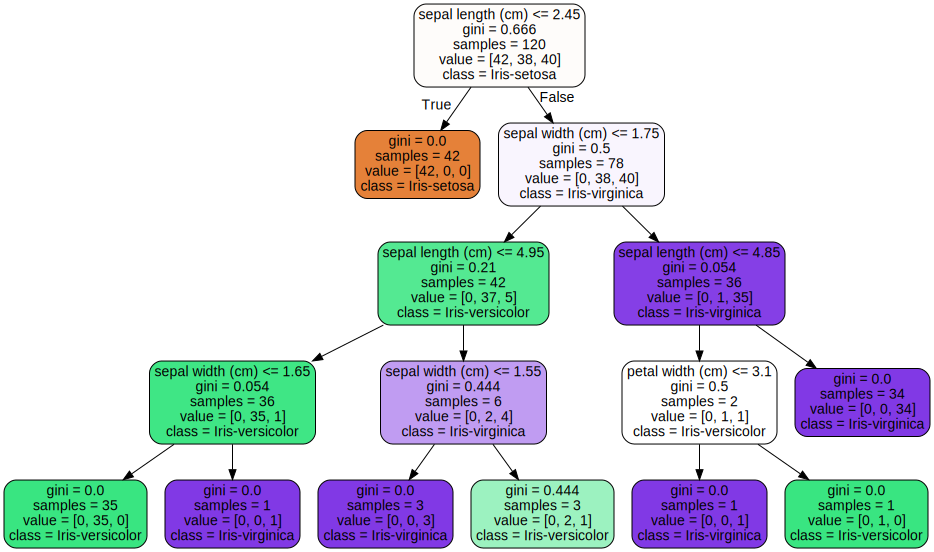

In [199]:
from graphviz import Source #Printing decision tree with all features
Source.from_file("iris_tree.dot")

In [200]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# predictions on training and testing data
y_train_pred = tree_clf_i.predict(X_train_plpw)
y_test_pred = tree_clf_i.predict(X_test_plpw)

# calculating accuracy on training and testing data
train_accuracy = accuracy_score(y_train_tok, y_train_pred)
test_accuracy = accuracy_score(y_test_tok, y_test_pred)

# computing precision, recall, F1 scores on training and testing data
train_precision, train_recall, train_f1_score, _ = precision_recall_fscore_support(y_train_tok, y_train_pred, average='weighted')
test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(y_test_tok, y_test_pred, average='weighted')

# confusion matrix for training and testing data
train_conf_matrix = confusion_matrix(y_train_tok, y_train_pred)
test_conf_matrix = confusion_matrix(y_test_tok, y_test_pred)

In [201]:
# Printing results
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

print("\nTraining Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1_score)

print("\nTest Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1_score)

print("\nConfusion Matrix (Training Data):\n", train_conf_matrix)
print("\nConfusion Matrix (Test Data):\n", test_conf_matrix)

Training Accuracy: 0.9916666666666667
Test Accuracy: 1.0

Training Precision: 0.9918803418803418
Training Recall: 0.9916666666666667
Training F1 Score: 0.9916680366047453

Test Precision: 1.0
Test Recall: 1.0
Test F1 Score: 1.0

Confusion Matrix (Training Data):
 [[42  0  0]
 [ 0 38  0]
 [ 0  1 39]]

Confusion Matrix (Test Data):
 [[ 8  0  0]
 [ 0 12  0]
 [ 0  0 10]]


# Discussion
The model appears to perform very well on both the training and testing sets. The model has an accuracy score of .99 on the training set and 1.0 on the test set. I believe that these scores are this high because I believe that the ideal max depth is 4 for this decision tree. My reasoning for this is that this is the value that results in the highest accuracy scores for the model. When compared to the bivariate model results obtained in the class, this model performs even better. The in class model resulted in accuracy scores of .98 and .96, which are slighly lower than the scores found through this model. The same applies for the precision, recall, and F1 scores.

# Exercise 2 - Decision tree on obesity data

Train a decision tree that is able to predict a person's degree of obesity based on their eating and exercise habits.  

* Once your model is trained, evaluate its accuracy on the training and test data.  Present and discuss the **precision, recall, F1 scores, and the confusion matrix.**  

* For your decision tree, present the **max_depth** value that results in the best model performance overall on the training and test data and explain how you determined this value.  

* Compare your results to the multivariate SGD classifier and the SVM classifier from problem #1 in the previous homework (you may use my solutions or your own).

* Present your final discussion/comparison in a seprate Markdown cell at the end of your analysis

### Preparing the dataframe

This dataset was retrieve from Kaggle.  It contains peronal demographic information and attributes related to eating habits for 2111 individuals.  The question is, **how well can we predict obesity based on calorie intake and expenditure**

Personal Demographic features are:
Gender, Age, Height, Weight, family history

Attributes related to eating habits:
* FAVC - Frequent of consumption of high caloric food (yes/no)
* FCVC - Frequency of consumption of vegetables (servg per day)
* NCP - Number of main meals (1-4)
* CAEC - Consumption of food between meals (Sometimes', 'Frequently', 'Always', 'no')
* SMOKE - Smoking (yes/no)
* CH20 - Daily consumption of water (1-3 L)
* SCC - Caloric consumption monitoring (yes/no)
* FAF - Physical activity frequency (0-3 hours)
* TUE - Time using technology devices (0-2 hours)
* CALC - Consumption of alcohol ('no', 'Sometimes', 'Frequently', 'Always')
* MTRANS - Transportation used ('Public_Transportation', 'Walking', 'Automobile', 'Motorbike', 'Bike')
* NObeyesdad - Degree of obesity (Underweight, Normal, Overweight_I,
 Overweight_II, Obesity_I, Obesity_II, Obesity_III)

In [202]:
web_path = 'http://public.gettysburg.edu/~rjohnson/ds325/' #if using data over web
df_o = pd.read_csv(web_path+'ObesityDataSet.csv')


In [203]:
#df_o.info()

Our task will be to train a classifier that can predict a person's degree of obesity based on their eating and exercise habits.  Since we want a person's obesity class to be a function only of these variables, we will intentionally ignore Age, Height, and Weight (which most certainly are correlated with obesity).  The strategy will be to:

* convert categorical features to numerical
* examine variable distribution for stratifying purposes
* train a decision tree
* determine the optimal tree depth that maximizes both our training and testing performance


In [204]:
# rename columns
df_o.rename(columns={"family_history_with_overweight": "hist"}, inplace=True)
df_o.rename(columns={"NObeyesdad": "obes"}, inplace=True)

In [205]:
# I'm manually encoding the obesity classification because when I used
# LabelEncoder(), it put them in alphabetical order, which wasn't helpful

df_o['obes'].replace({'Insufficient_Weight':0, 'Normal_Weight':1,
                                'Overweight_Level_I':2, 'Overweight_Level_II':3,
                                'Obesity_Type_I':4, 'Obesity_Type_II':5,
                                'Obesity_Type_III':6},inplace=True)

In [206]:
df_o

,Gender,Age,Height,Weight,hist,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,obes
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,1
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,1
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,1
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,2
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,6
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,6
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,6
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,6


In [207]:
# here we encode all of the non-numerical features
# using LabelEncoder and replace our dataframe
le_hist = LabelEncoder()
dft = le_hist.fit_transform(df_o['hist'])
df_o['hist'] = dft

le_gen = LabelEncoder()
dft = le_gen.fit_transform(df_o['Gender'])
df_o['Gender'] = dft

le_favc = LabelEncoder()
dft = le_favc.fit_transform(df_o['FAVC'])
df_o['FAVC'] = dft

le_caec = LabelEncoder()
dft = le_caec.fit_transform(df_o['CAEC'])
df_o['CAEC'] = dft

le_smoke = LabelEncoder()
dft = le_smoke.fit_transform(df_o['SMOKE'])
df_o['SMOKE'] = dft

le_scc = LabelEncoder()
dft = le_scc.fit_transform(df_o['SCC'])
df_o['SCC'] = dft

le_calc = LabelEncoder()
dft = le_calc.fit_transform(df_o['CALC'])
df_o['CALC'] = dft

le_mtrans = LabelEncoder()
dft = le_mtrans.fit_transform(df_o['MTRANS'])
df_o['MTRANS'] = dft

In [208]:
feat = df_o.drop('obes', axis=1, inplace=False)
targ = df_o['obes']

X_train, X_test, y_train, y_test = train_test_split(feat, targ, test_size=0.2,
                                                   random_state=42)



In [209]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1688 entries, 162 to 860
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  1688 non-null   int64  
 1   Age     1688 non-null   float64
 2   Height  1688 non-null   float64
 3   Weight  1688 non-null   float64
 4   hist    1688 non-null   int64  
 5   FAVC    1688 non-null   int64  
 6   FCVC    1688 non-null   float64
 7   NCP     1688 non-null   float64
 8   CAEC    1688 non-null   int64  
 9   SMOKE   1688 non-null   int64  
 10  CH2O    1688 non-null   float64
 11  SCC     1688 non-null   int64  
 12  FAF     1688 non-null   float64
 13  TUE     1688 non-null   float64
 14  CALC    1688 non-null   int64  
 15  MTRANS  1688 non-null   int64  
dtypes: float64(8), int64(8)
memory usage: 224.2 KB


# Solution

In [210]:
tree_clf_2 = DecisionTreeClassifier(max_depth=8, random_state=42) #Creating decision tree model
#with different max depth values
tree_clf_2.fit(X_train, y_train) #Fitting model

DecisionTreeClassifier(max_depth=8, random_state=42)

In [211]:
# predictions on training and testing data
y_train_pred = tree_clf_2.predict(X_train)
y_test_pred = tree_clf_2.predict(X_test)

# calculating accuracy on training and testing data
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# computing precision, recall, F1 scores on training and testing data
train_precision, train_recall, train_f1_score, _ = precision_recall_fscore_support(y_train, y_train, average='weighted')
test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(y_test, y_test, average='weighted')

# confusion matrix for training and testing data
train_conf_matrix = confusion_matrix(y_train, y_train)
test_conf_matrix = confusion_matrix(y_test, y_test)

In [212]:
# printing results
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

print("\nTraining Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1_score)

print("\nTest Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1_score)

print("\nConfusion Matrix (Training Data):\n", train_conf_matrix)
print("\nConfusion Matrix (Test Data):\n", test_conf_matrix)

Training Accuracy: 0.9875592417061612
Test Accuracy: 0.9432624113475178

Training Precision: 1.0
Training Recall: 1.0
Training F1 Score: 1.0

Test Precision: 1.0
Test Recall: 1.0
Test F1 Score: 1.0

Confusion Matrix (Training Data):
 [[216   0   0   0   0   0   0]
 [  0 225   0   0   0   0   0]
 [  0   0 234   0   0   0   0]
 [  0   0   0 240   0   0   0]
 [  0   0   0   0 273   0   0]
 [  0   0   0   0   0 239   0]
 [  0   0   0   0   0   0 261]]

Confusion Matrix (Test Data):
 [[56  0  0  0  0  0  0]
 [ 0 62  0  0  0  0  0]
 [ 0  0 56  0  0  0  0]
 [ 0  0  0 50  0  0  0]
 [ 0  0  0  0 78  0  0]
 [ 0  0  0  0  0 58  0]
 [ 0  0  0  0  0  0 63]]


# Discussion
The model appears to perform better on the training set as the accuracy score is .98 whereas the accuracy score is only .94 on the testing set. The precision, recall, and F1 scores are identical, making the accuracy scores the best metric for comparisson. The max depth that I found to be most effective was 8 because the accuracy scores appeared to be lower for other values that I tried. I came to this conclusion by inputting numbers 1-10 and seeing the resulting scores. Compared to the results from the previous homework, this model seemed to perform significantly better as the accuracy scores from those models ranged from 40 to 60 percent. This model, however, resulted in accuracy scores above 90% on the training and testing scores.

#Exercise 3 - Separating Moons (LinearSVM, SVM, DT, SGD)
In the following problem, I have used Sklearn's **make_moons** method in order to generate 4 interleaving clusters of points.  Your job is to train several classifiers to determine which performs best on this non-linearly separable dataset.  Using the provided data, train your best classifier using each of the following algorithms:
* linearSVM with polynomial features
* SVM with polynomial kernel
* Decision Tree
* SGD  

For each model, be sure to:
* specify and justify your choice of hyperparameters (polynomial degree, decision tree depth, etc.)
* evaluate your model's accuracy on the training data and test data using the provided class_performance method (or the equivalent).  

Present your final discussion/comparison of your models in a seprate Markdown cell at the end of your analysis

## Generating Moons data

In [213]:
# some helper functions for plotting the moons data
def plot_dataset1(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.plot(X[:, 0][y==2], X[:, 1][y==2], "yo")
    plt.plot(X[:, 0][y==3], X[:, 1][y==3], "r*")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_dataset2(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "kx")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "kx")
    plt.plot(X[:, 0][y==2], X[:, 1][y==2], "kx")
    plt.plot(X[:, 0][y==3], X[:, 1][y==3], "kx")
    plt.axis(axes)
    plt.grid(True)


In [214]:
X, y = make_moons(n_samples=200, noise=0.15, random_state=42)
X2, y2 = make_moons(n_samples=200, noise=0.15, random_state=42)

# change cluster numbers
y2 = y2+2

# Define the angle of rotation in radians
theta = np.radians(90)

# Calculate the sine and cosine of the angle
c, s = np.cos(theta), np.sin(theta)

# Create the rotation matrix
R = np.array(((c, -s), (s, c)))

# Define the vector to be rotated
v = np.array(X2)

# Rotate the vector using the rotation matrix
X2r = np.dot(v, R)

# adjust positions of moons so they don't overlap too much
for i in range(len(X)):
  if y[i] == 0:
    X[i,1] = X[i,1]
  if y[i] == 1:
    X[i,1] = X[i,1]-1

for i in range(len(X2r)):
  if y2[i] == 2:
    X2r[i,0] = X2r[i,0]+0.5
  if y2[i] == 3:
    X2r[i,0] = X2r[i,0]

xall = np.concatenate((X, X2r), axis=0)
yall = np.concatenate((y, y2), axis=None)

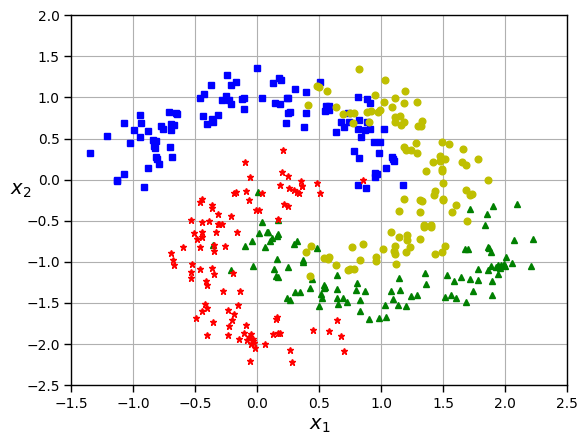

In [215]:
plot_dataset1(xall, yall, [-1.5, 2.5, -2.5, 2])

plt.show()

In [216]:
# train test split
# setup the training features and target; train/test split stratified on age

X_train, X_test, y_train, y_test = train_test_split(xall, yall, test_size=0.2,
                                                   random_state=42)


# Solution

In [217]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42) #generating dataset using make moons method

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #train test split

In [219]:
polynomial_svm_clf = make_pipeline(PolynomialFeatures(degree=3),StandardScaler(),LinearSVC(C=10, max_iter=10_000, dual=True, random_state=42))
polynomial_svm_clf.fit(X_train, y_train) #fitting svm model
polynomial_svm_test_pred = polynomial_svm_clf.predict(X_test) #predicting using svm polynomial features on test set
polynomial_svm_train_pred = polynomial_svm_clf.predict(X_train) #predicting using svm polynomial features on train set
polynomial_svm_test_accuracy = accuracy_score(y_test, polynomial_svm_test_pred) #finding accuracy of model on test set
polynomial_svm_train_accuracy = accuracy_score(y_train, polynomial_svm_train_pred) #finding accuracy of model on training set

In [220]:
poly_kernel_svc_clf = make_pipeline(StandardScaler(), SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svc_clf.fit(X_train, y_train) #fitting kernel svm model
poly_kernel_svc_pred = poly_kernel_svc_clf.predict(X_test) #predicting using test kernel svm
poly_kernel_svc_train_pred = poly_kernel_svc_clf.predict(X_train) #predicting using train kernel svm
poly_kernel_svc_accuracy = accuracy_score(y_test, poly_kernel_svc_pred) #finding accuracy of model on test set
poly_kernel_svc_train_accuracy = accuracy_score(y_train, poly_kernel_svc_train_pred) #finding accuracy of model on training set

In [221]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train, y_train) #fitting decision tree model
tree_pred = tree_clf.predict(X_test) #predicting using test decision tree
tree_pred_train = tree_clf.predict(X_train) #predicting using train decision tree
tree_accuracy = accuracy_score(y_test, tree_pred) #finding accuracy of model on test set
tree_accuracy_train = accuracy_score(y_train, tree_pred_train) #finding accuracy of model on training set

In [222]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train) #fitting SGDClassifier model
sgd_pred = sgd_clf.predict(X_test) #predicting using test SGDClassifier
sgd_pred_train = sgd_clf.predict(X_train) #predicting using train SGDClassifier
sgd_accuracy = accuracy_score(y_test, sgd_pred) #finding accuracy of model on test set
sgd_accuracy_train = accuracy_score(y_train, sgd_pred_train) #finding accuracy of model on training set

In [223]:
print("Accuracy of Linear SVM with polynomial features on test set:", polynomial_svm_test_accuracy) #printing accuracy of all models
print("Accuracy of SVM with polynomial kernel on test set:", poly_kernel_svc_accuracy)
print("Accuracy of Decision Tree on test set:", tree_accuracy)
print("Accuracy of SGD on test set:", sgd_accuracy)
print("Accuracy of Linear SVM with polynomial features on train set:", polynomial_svm_train_accuracy) #printing accuracy of all models
print("Accuracy of SVM with polynomial kernel on train set:", poly_kernel_svc_train_accuracy)
print("Accuracy of Decision Tree on train set:", tree_accuracy_train)
print("Accuracy of SGD on train set:", sgd_accuracy_train)

Accuracy of Linear SVM with polynomial features on test set: 0.9
Accuracy of SVM with polynomial kernel on test set: 0.9
Accuracy of Decision Tree on test set: 1.0
Accuracy of SGD on test set: 0.95
Accuracy of Linear SVM with polynomial features on train set: 0.9875
Accuracy of SVM with polynomial kernel on train set: 0.975
Accuracy of Decision Tree on train set: 0.9125
Accuracy of SGD on train set: 0.8


# Discussion
Each of the models above were tested against the testing and training sets. In general, the decision tree model performed best overall because the accuracy was 1.0 on the testing set and .9125 on the training set. The other models performed better on the training set but not quite as well on the test set. The second best performing model was the Linear SVM with polynomial features with a .9 accuracy score on the testing set and .9875 accuracy score on the training set. The third best model was the SVM with polynomial kernel with accuracy scores of .9 and .9125 respectively. Finally, the worst model was the SGD model with accuracy scores of only .95 and .8 respectively. I chose to input a polynomial degree of 3 for my polynomial models because the accuracy values (in general on both training and testing set) seemed to be highest with this value. Additionally, I chose a maximum decision tree depth of 2 because the testing set accuracy was lower than 1 with a maximum tree depth of 1.